In [318]:
import rasterio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2

In [319]:
true_color = np.array(Image.open("./2024-11-12-00_00_2024-11-12-23_59_Sentinel-2_L1C_True_color.jpg"))
ndvi = np.array(Image.open("./2024-11-12-00_00_2024-11-12-23_59_Sentinel-2_L1C_NDVI.jpg"))
true_color = true_color / 255.0
ndvi = ndvi / 255.0



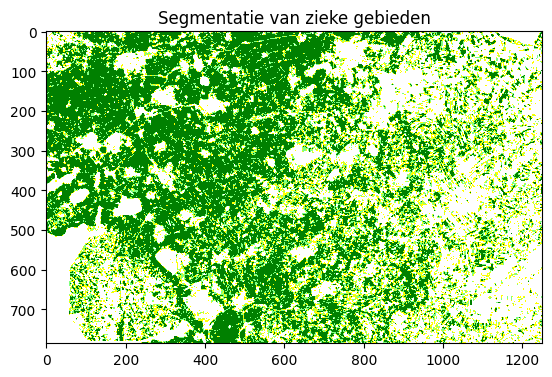

In [320]:
threshold = 0.2
labels = (ndvi < threshold).astype(int)
labels = labels[:, :, 0]
cmap = plt.cm.colors.ListedColormap(['white','yellow',(0.5, 1, 0.5, 1), 'green'])
plt.imshow(labels, cmap=cmap)
plt.title('Segmentatie van zieke gebieden')
plt.show()

In [321]:
ndvi_test = ndvi[:, :, 0]
segmented = np.uint8((ndvi_test < threshold) * 255)
contours, hierarchy = cv2.findContours(segmented, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
ndvi_copy = np.copy(ndvi)
total_area = 0
for contour in contours:
    area = cv2.contourArea(contour)
    total_area += area
pixel_size = 10
real_world_area = total_area * (pixel_size ** 2)
print(real_world_area)

89421400.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


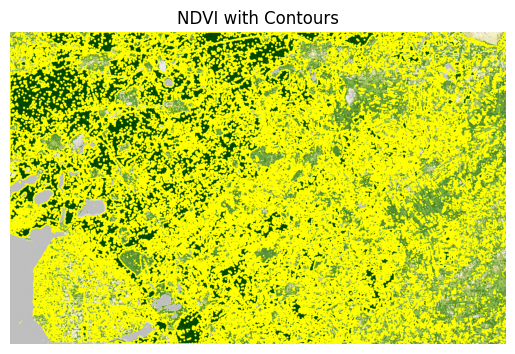

In [322]:
cv2.drawContours(ndvi_copy, contours, -1, (255, 255, 0), 2)
# contourim = cv2.resize(ndvi_copy,(1080,1080))
# cv2.imshow('Contours',contourim)
plt.imshow(ndvi_copy, cmap='RdYlGn', vmin=0, vmax=1)
plt.title('NDVI with Contours')
plt.axis('off')
plt.show()

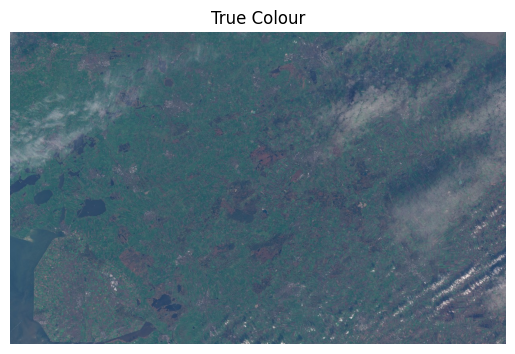

Shape of true_color_image: (786, 1250, 3)
Shape of labels: (786, 1250)
(982500, 3)
(982500,)


In [323]:
true_color = np.array(Image.open("./2024-11-12-00_00_2024-11-12-23_59_Sentinel-2_L1C_True_color.jpg"))
ndvi = np.array(Image.open("./2024-11-12-00_00_2024-11-12-23_59_Sentinel-2_L1C_NDVI.jpg"))
true_color = true_color / 255.0
ndvi = ndvi / 255.0
labels = (ndvi < threshold).astype(int)
labels = labels[:, :, 0]
plt.imshow(true_color)
plt.title('True Colour')
plt.axis('off')
plt.show()

H, W, C = true_color.shape
X = true_color.reshape(-1, C)
y = labels.flatten()
print(f"Shape of true_color_image: {true_color.shape}")  # (H, W, C)
print(f"Shape of labels: {labels.shape}")  # (H, W)
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [324]:
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8163765903307888


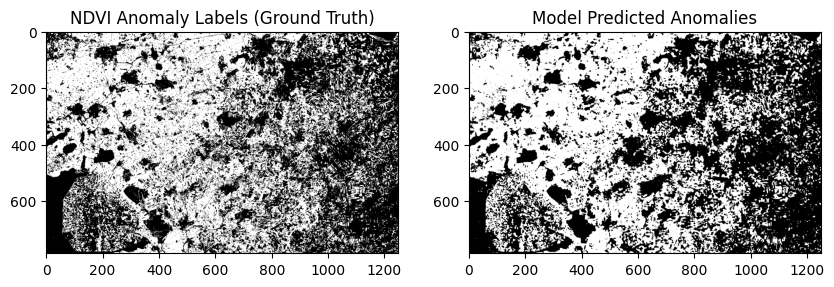

In [325]:
predictions = model.predict(X).reshape(H, W)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(labels, cmap='gray')
plt.title('NDVI Anomaly Labels (Ground Truth)')
plt.subplot(1, 2, 2)
plt.imshow(predictions, cmap='gray')
plt.title('Model Predicted Anomalies')
plt.show()


In [326]:
y_true = labels.flatten()
y_pred = predictions.flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81    472862
           1       0.83      0.82      0.83    509638

    accuracy                           0.82    982500
   macro avg       0.82      0.82      0.82    982500
weighted avg       0.82      0.82      0.82    982500

Confusion Matrix:
[[387072  85790]
 [ 90008 419630]]


In [327]:
X = true_color / 255.0
print(X.shape)
print(labels.shape)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)



(786, 1250, 3)
(786, 1250)
(628, 1250, 1)
(158, 1250, 1)
(628, 1250, 3)
(158, 1250, 3)


In [328]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(628, 1250, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 628, 1250, 32)     896       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 314, 625, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 314, 625, 64)      18496     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 157, 313, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_90 (Conv2D)          (None, 157, 313, 128)     73856     
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 79, 157, 128)    

In [329]:
# from skimage.transform import resize

# y_train = resize(y_train, (157, 313, 1), mode='constant', preserve_range=True)
# y_test = resize(y_test, (157, 313, 1), mode='constant', preserve_range=True)

X_train = np.expand_dims(X_train, axis=0)
X_test = np.expand_dims(X_test, axis=0)

y_train = np.expand_dims(y_train, axis=0)
y_test = np.expand_dims(y_test, axis=0)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_test, y_test)
)

(1, 628, 1250, 1)
(1, 158, 1250, 1)
(1, 628, 1250, 3)
(1, 158, 1250, 3)
Epoch 1/10


ValueError: in user code:

    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\jarne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 79, 157, 1) vs (None, 628, 1250, 1)).


In [ ]:
predictions = model.predict(X_test)

binary_predictions = (predictions > 0.5).astype(int)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("True-Color Image")
plt.imshow(X_test[0])

plt.subplot(1, 3, 2)
plt.title("Ground Truth (NDVI Labels)")
plt.imshow(y_test[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Anomalies")
plt.imshow(binary_predictions[0].squeeze(), cmap='gray')
plt.show()